In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS

In [2]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))
        
def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Load data

In [24]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/distance_frame.pkl")

In [25]:
model_frame = model_skeleton.set_index(["origin","status"])

In [26]:
reference_distances = model_frame.loc[("unpermuted","original"),"all_distances"]

In [27]:
distances = model_frame["all_distances"]

In [28]:
!pwd

/home/jakobpp/BayesianGEM/code


### Visualize particle population

In [29]:
unique_origins = model_frame.index.get_level_values("origin").unique()

In [30]:
combined_df_metadata = load_pickle("../results/permuted_smcabc_res/combined_df_metadata.pkl")

In [31]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

(63139,)
(61724,)
(62675,)
(62990,)
(63474,)
(62980,)
(62952,)
(63087,)


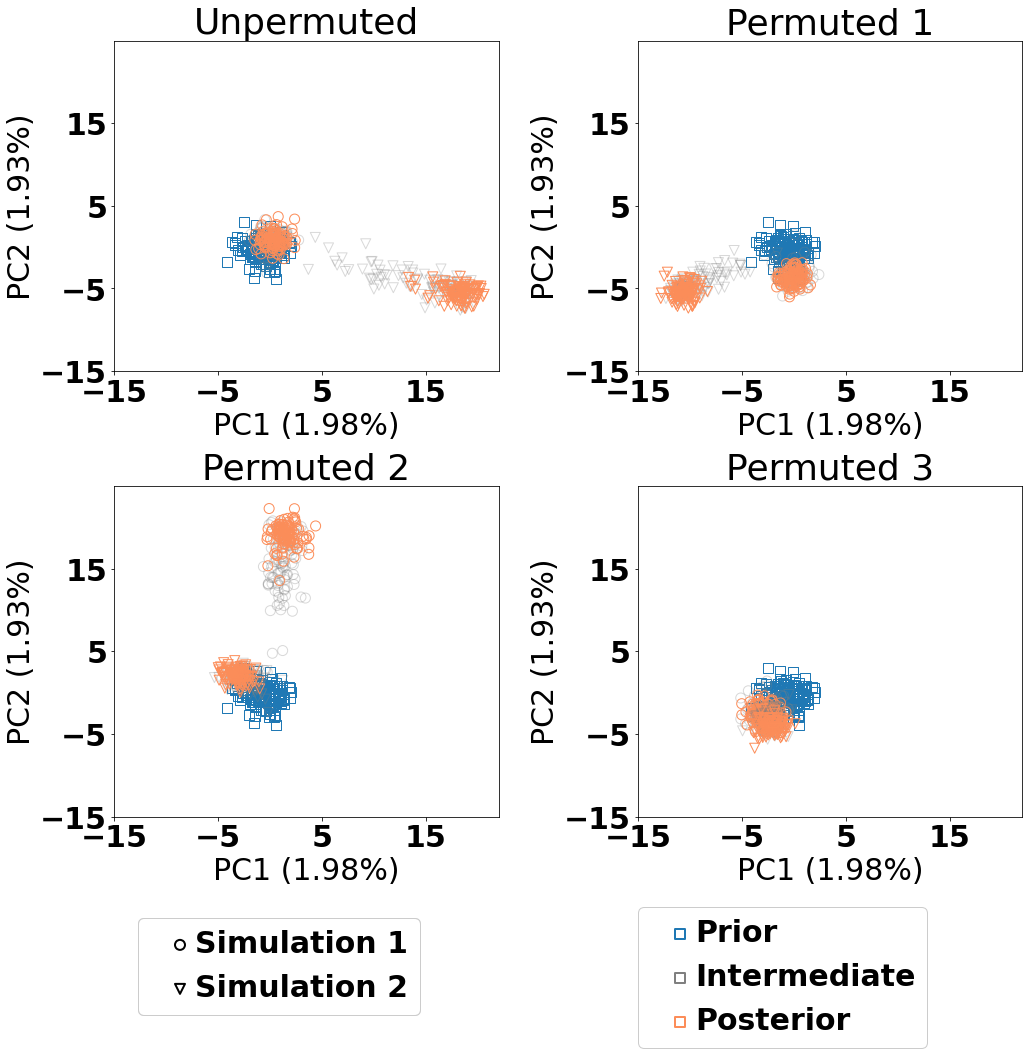

In [32]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
prior = combined_df_metadata["origin"].to_numpy()
model = combined_df_metadata["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-15,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-15,22))
    plt.ylim((-15,25))
    plt.title(proper_names[origin])
    plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc=(0,-.7), framealpha=1, handletextpad=-.5)
legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc=(-1.3,-.6), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_status)
plt.gcf().subplots_adjust(bottom=.22)
# plt.savefig("../figures/pca.png",dpi=300)
plt.show()

In [33]:
this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}

In [34]:
len(this_idxs["Posterior"])

5938

## $R^2$ convergence plots

In [35]:
def plot_convergence_inner(distances, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    r2s_history = -np.array(distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(distances):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

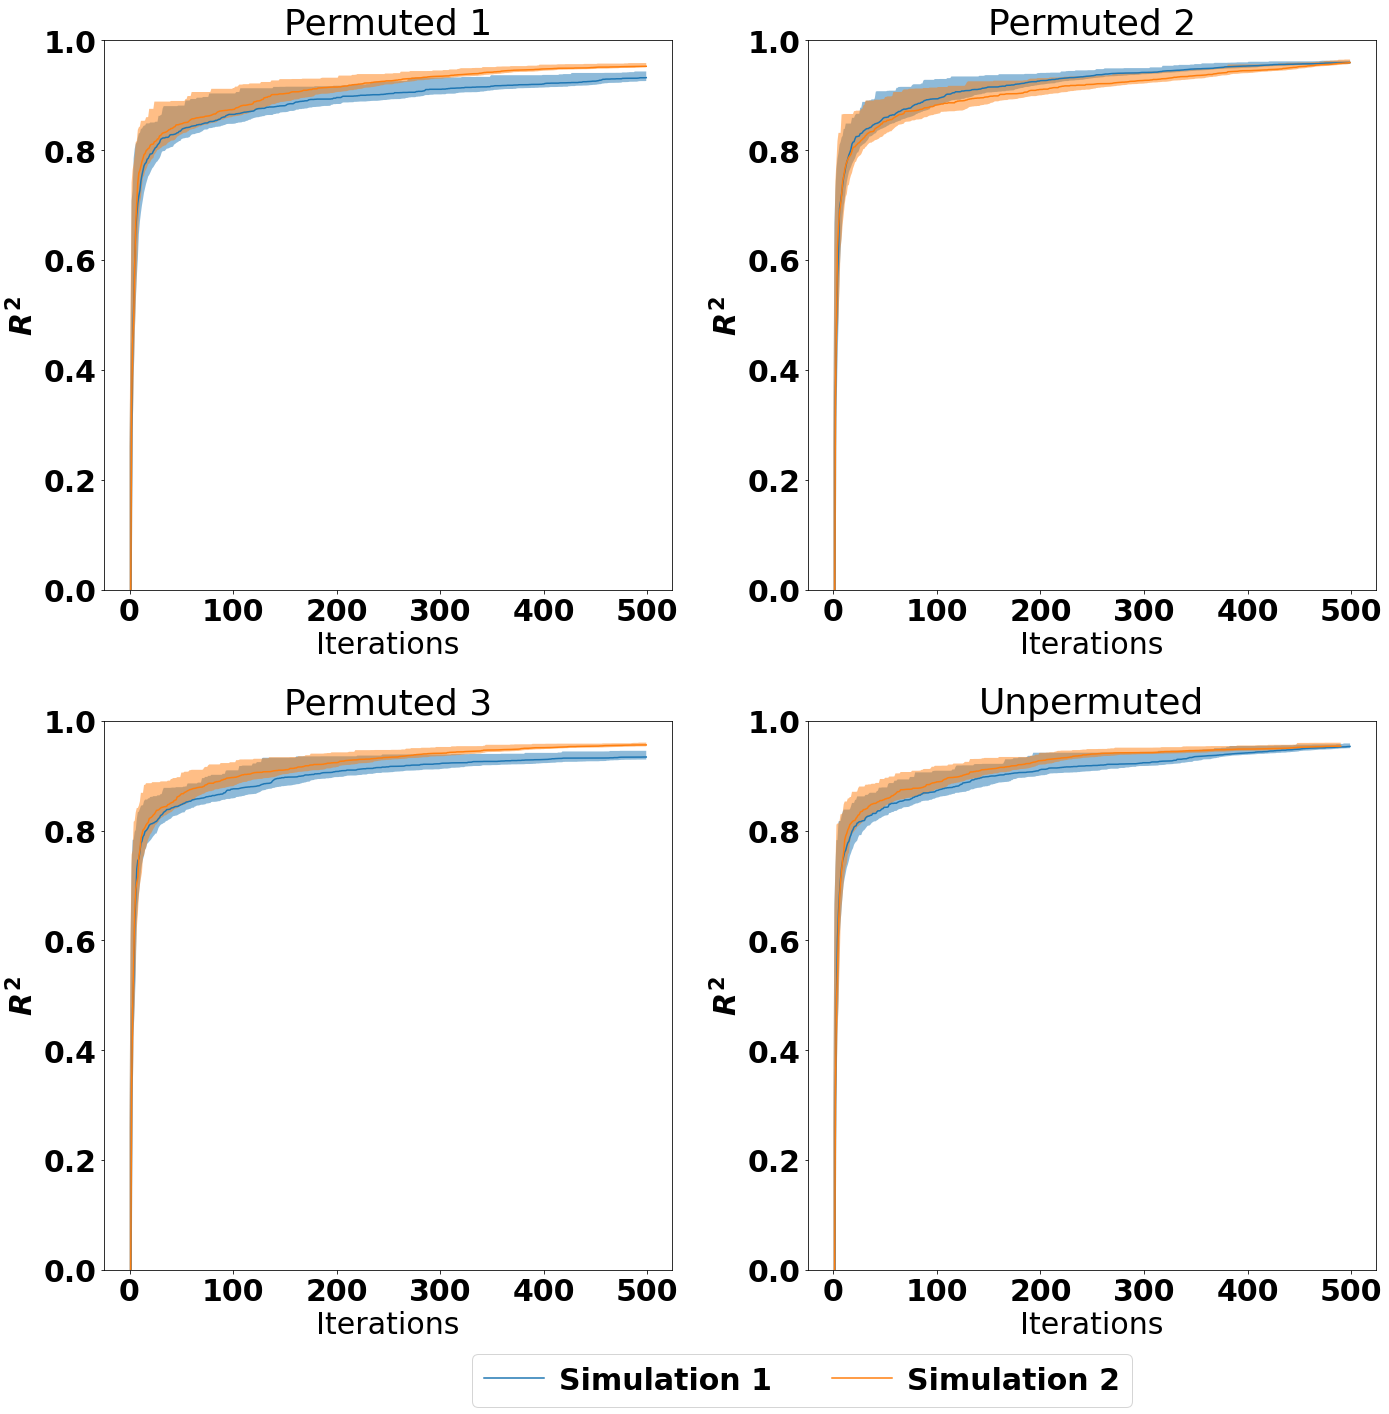

In [36]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
for index, series in model_frame["all_distances"].groupby("origin"):
    plt.subplot(2,2,i)
    origin_distances = series[index]
    # Simulation 1
    original_distances = origin_distances["original"]
    # Simulation 2
    replicate_distances = origin_distances["replicate"]
    plot_convergence_inner(original_distances,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_distances,maxiter, label = 'Simulation 2')
    if i==4:
        handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
    plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
# plt.savefig("../figures/R2.pdf")
plt.show()

## Create integrated plot for Unpermuted and Permuted 1

In [14]:
reduced_pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_reduced_ordination.pkl")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(63139,)
(61724,)
(62675,)
(62990,)


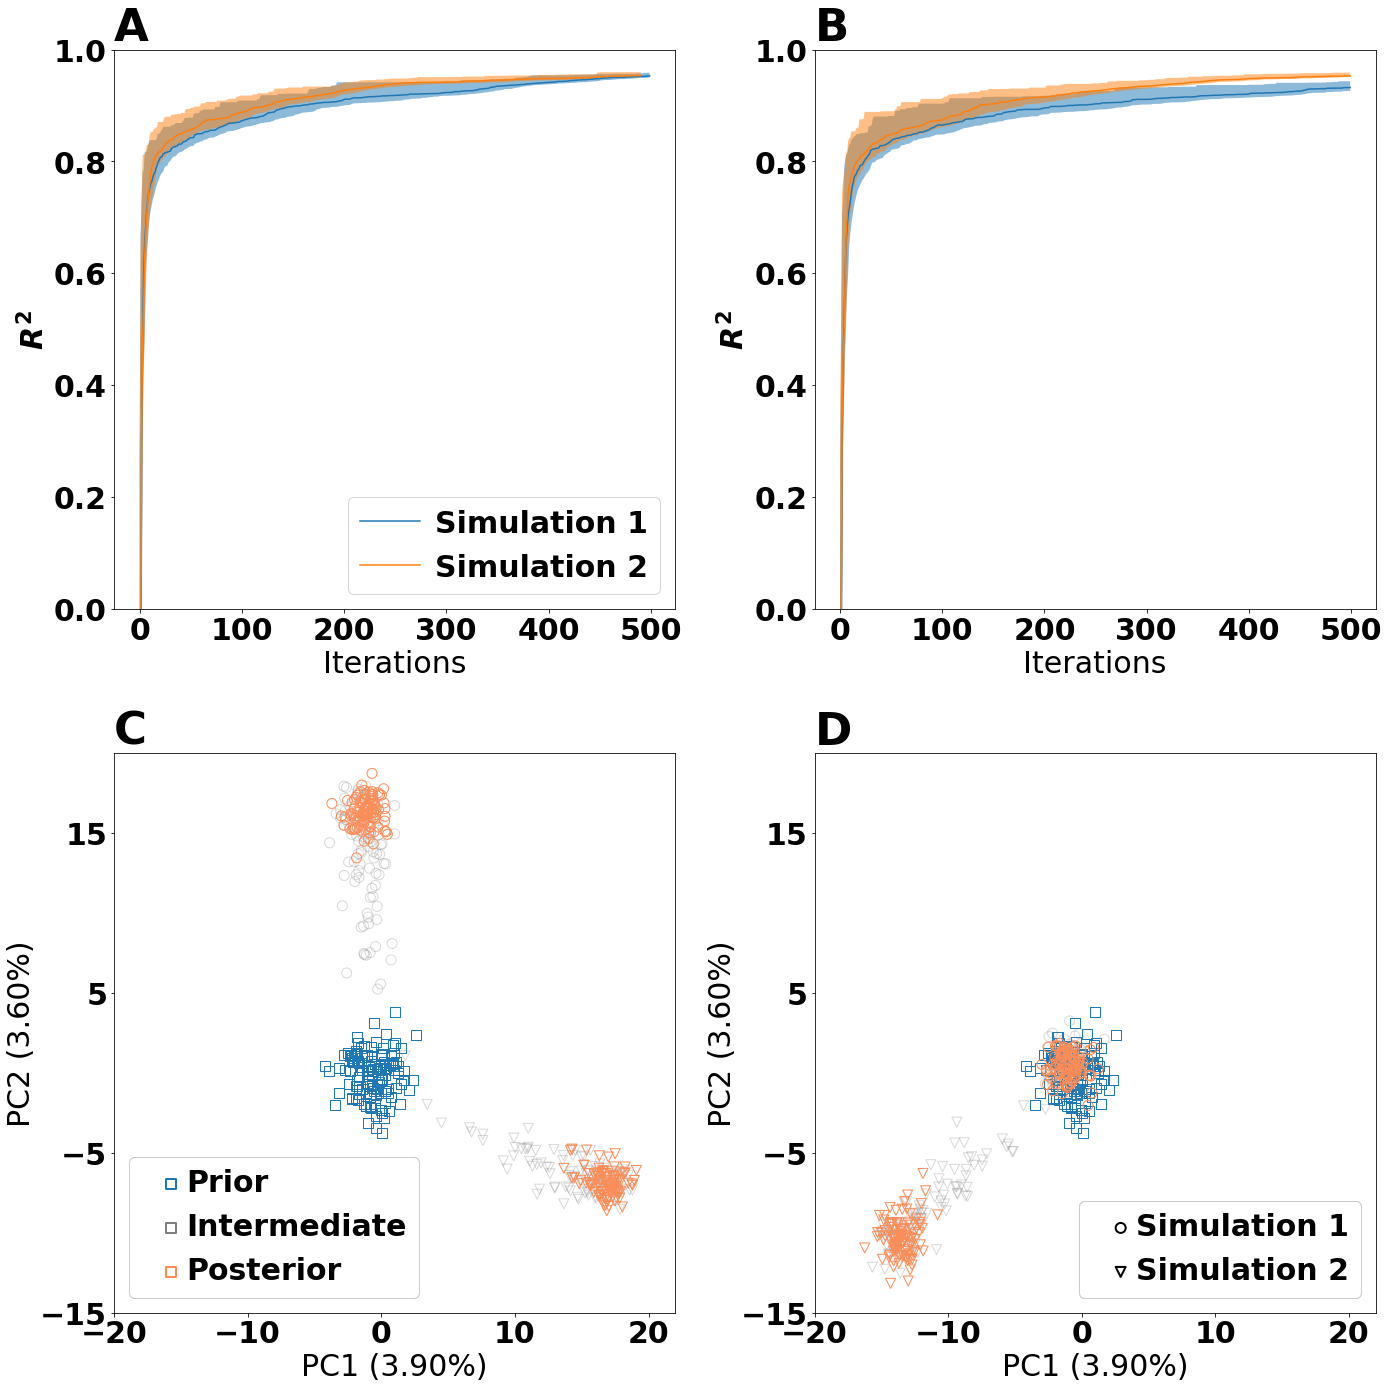

In [15]:
thinning_rng = np.random.default_rng(8049)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df_metadata["period"].to_numpy()
prior = combined_df_metadata["origin"].to_numpy()
model = combined_df_metadata["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
plt.figure(figsize=(20,20))
i=2
for index, series in model_frame.query("origin in ('unpermuted','permuted_0')")["all_distances"].groupby("origin"):
    plt.subplot(2,2,i)
    origin_distances = series[index]
    # Simulation 1
    original_distances = origin_distances["original"]
    # Simulation 2
    replicate_distances = origin_distances["replicate"]
    plot_convergence_inner(original_distances,maxiter, label = 'Simulation 1')
    plot_convergence_inner(replicate_distances,maxiter, label = 'Simulation 2')
    if i==1:
        plt.legend(loc="lower right",handletextpad=0.5)
        # handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title("A" if index=="unpermuted" else "B",loc="left",fontsize=45,fontweight="bold")
    i -= 1
    plt.tight_layout()
    
PCS, EV = reduced_pca_ordination
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
i=3
for origin in ["unpermuted","permuted_0"]:
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        if label=="original":
            plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-20,22,10))
    plt.yticks(np.arange(-15,25,10))
    plt.xlim((-20,22))
    plt.ylim((-15,20))
    plt.title("C" if origin=="unpermuted" else "D",loc="left",fontsize=45,fontweight="bold")
    if origin == "unpermuted":
        legend_period = plt.legend(handles_period, all_periods, loc="lower left", framealpha=1, handletextpad=-.5)
        plt.gca().add_artist(legend_period)
    else:
        legend_status = plt.legend(handles_model, ["Simulation 1", "Simulation 2"], loc="lower right", framealpha=1,handletextpad=-.5)
        plt.gca().add_artist(legend_status)
    plt.tight_layout()

# plt.savefig("../figures/bayesian_fig.png",dpi=300)
plt.show()

# Results of evolutionary algorithm

In [16]:
evolution_distances = load_pickle("../results/evo_distances.pkl")

In [17]:
def plot_convergence_and_compare_evolution(distances, reference_distances, maxiter=100, legend = True):
    plot_convergence_inner(distances, generation_size=100, maxiter=maxiter, label = 'Evolutionary')
    plot_convergence_inner(reference_distances, maxiter=maxiter, label = 'Bayesian')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend(loc="lower right",handletextpad=0.5)
    plt.tight_layout()

In [18]:
evolution_combined_df_metadata = load_pickle("../results/evo_combined_df_metadata.pkl")

In [19]:
PCS_evo,EV_evo = load_pickle("../results/evo_pca_full_ordination.pkl")

In [20]:
model = evolution_combined_df_metadata["model"].to_numpy()
period = evolution_combined_df_metadata["period"].to_numpy()
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

In [21]:
markers = ["o","v"]
marker_dict = {'Bayesian': "o", 'Evolutionary': 'v'}
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)

def create_evo_pca_plot(legend = True):
    for label in ["Bayesian","Evolutionary"]:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(this_idxs["Intermediate"])
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        # It does really only make sense display priors for the Bayesian approach as the evolutionary algorithm generates
        # seed individuals by another method and it thus is most fair to show the Bayesian priors for both of them
        if label == "Bayesian":
            plt.scatter(PCS_evo[this_idxs['Prior'],0],PCS_evo[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                        marker="s",facecolors='none', s=100)
        plt.scatter(PCS_evo[this_idxs["Intermediate"],0],PCS_evo[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.5,label='Intermediate',marker=marker, facecolors='none',s=100)
        plt.scatter(PCS_evo[this_idxs['Posterior'],0],PCS_evo[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    plt.xlabel('PC1 ({:.2f}%)'.format(EV_evo[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV_evo[1]*100))
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
    plt.xticks(np.arange(-10,50,10))
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels_period = ["Prior", "Intermediate", 'Posterior']
    labels_status = ['Bayesian', "Evolutionary"]
    if legend:
        f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
        handles_period = [f("s", color) for color in colors]
        handles_model = [f(marker, "k") for marker in markers]
        legend_period = plt.legend(handles_period, labels_period, loc=(.5,.1), framealpha=1)
        legend_model = plt.legend(handles_model, labels_status, loc=(.1,.1), framealpha=1)
        plt.gca().add_artist(legend_period)
        plt.gca().add_artist(legend_model)

[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)


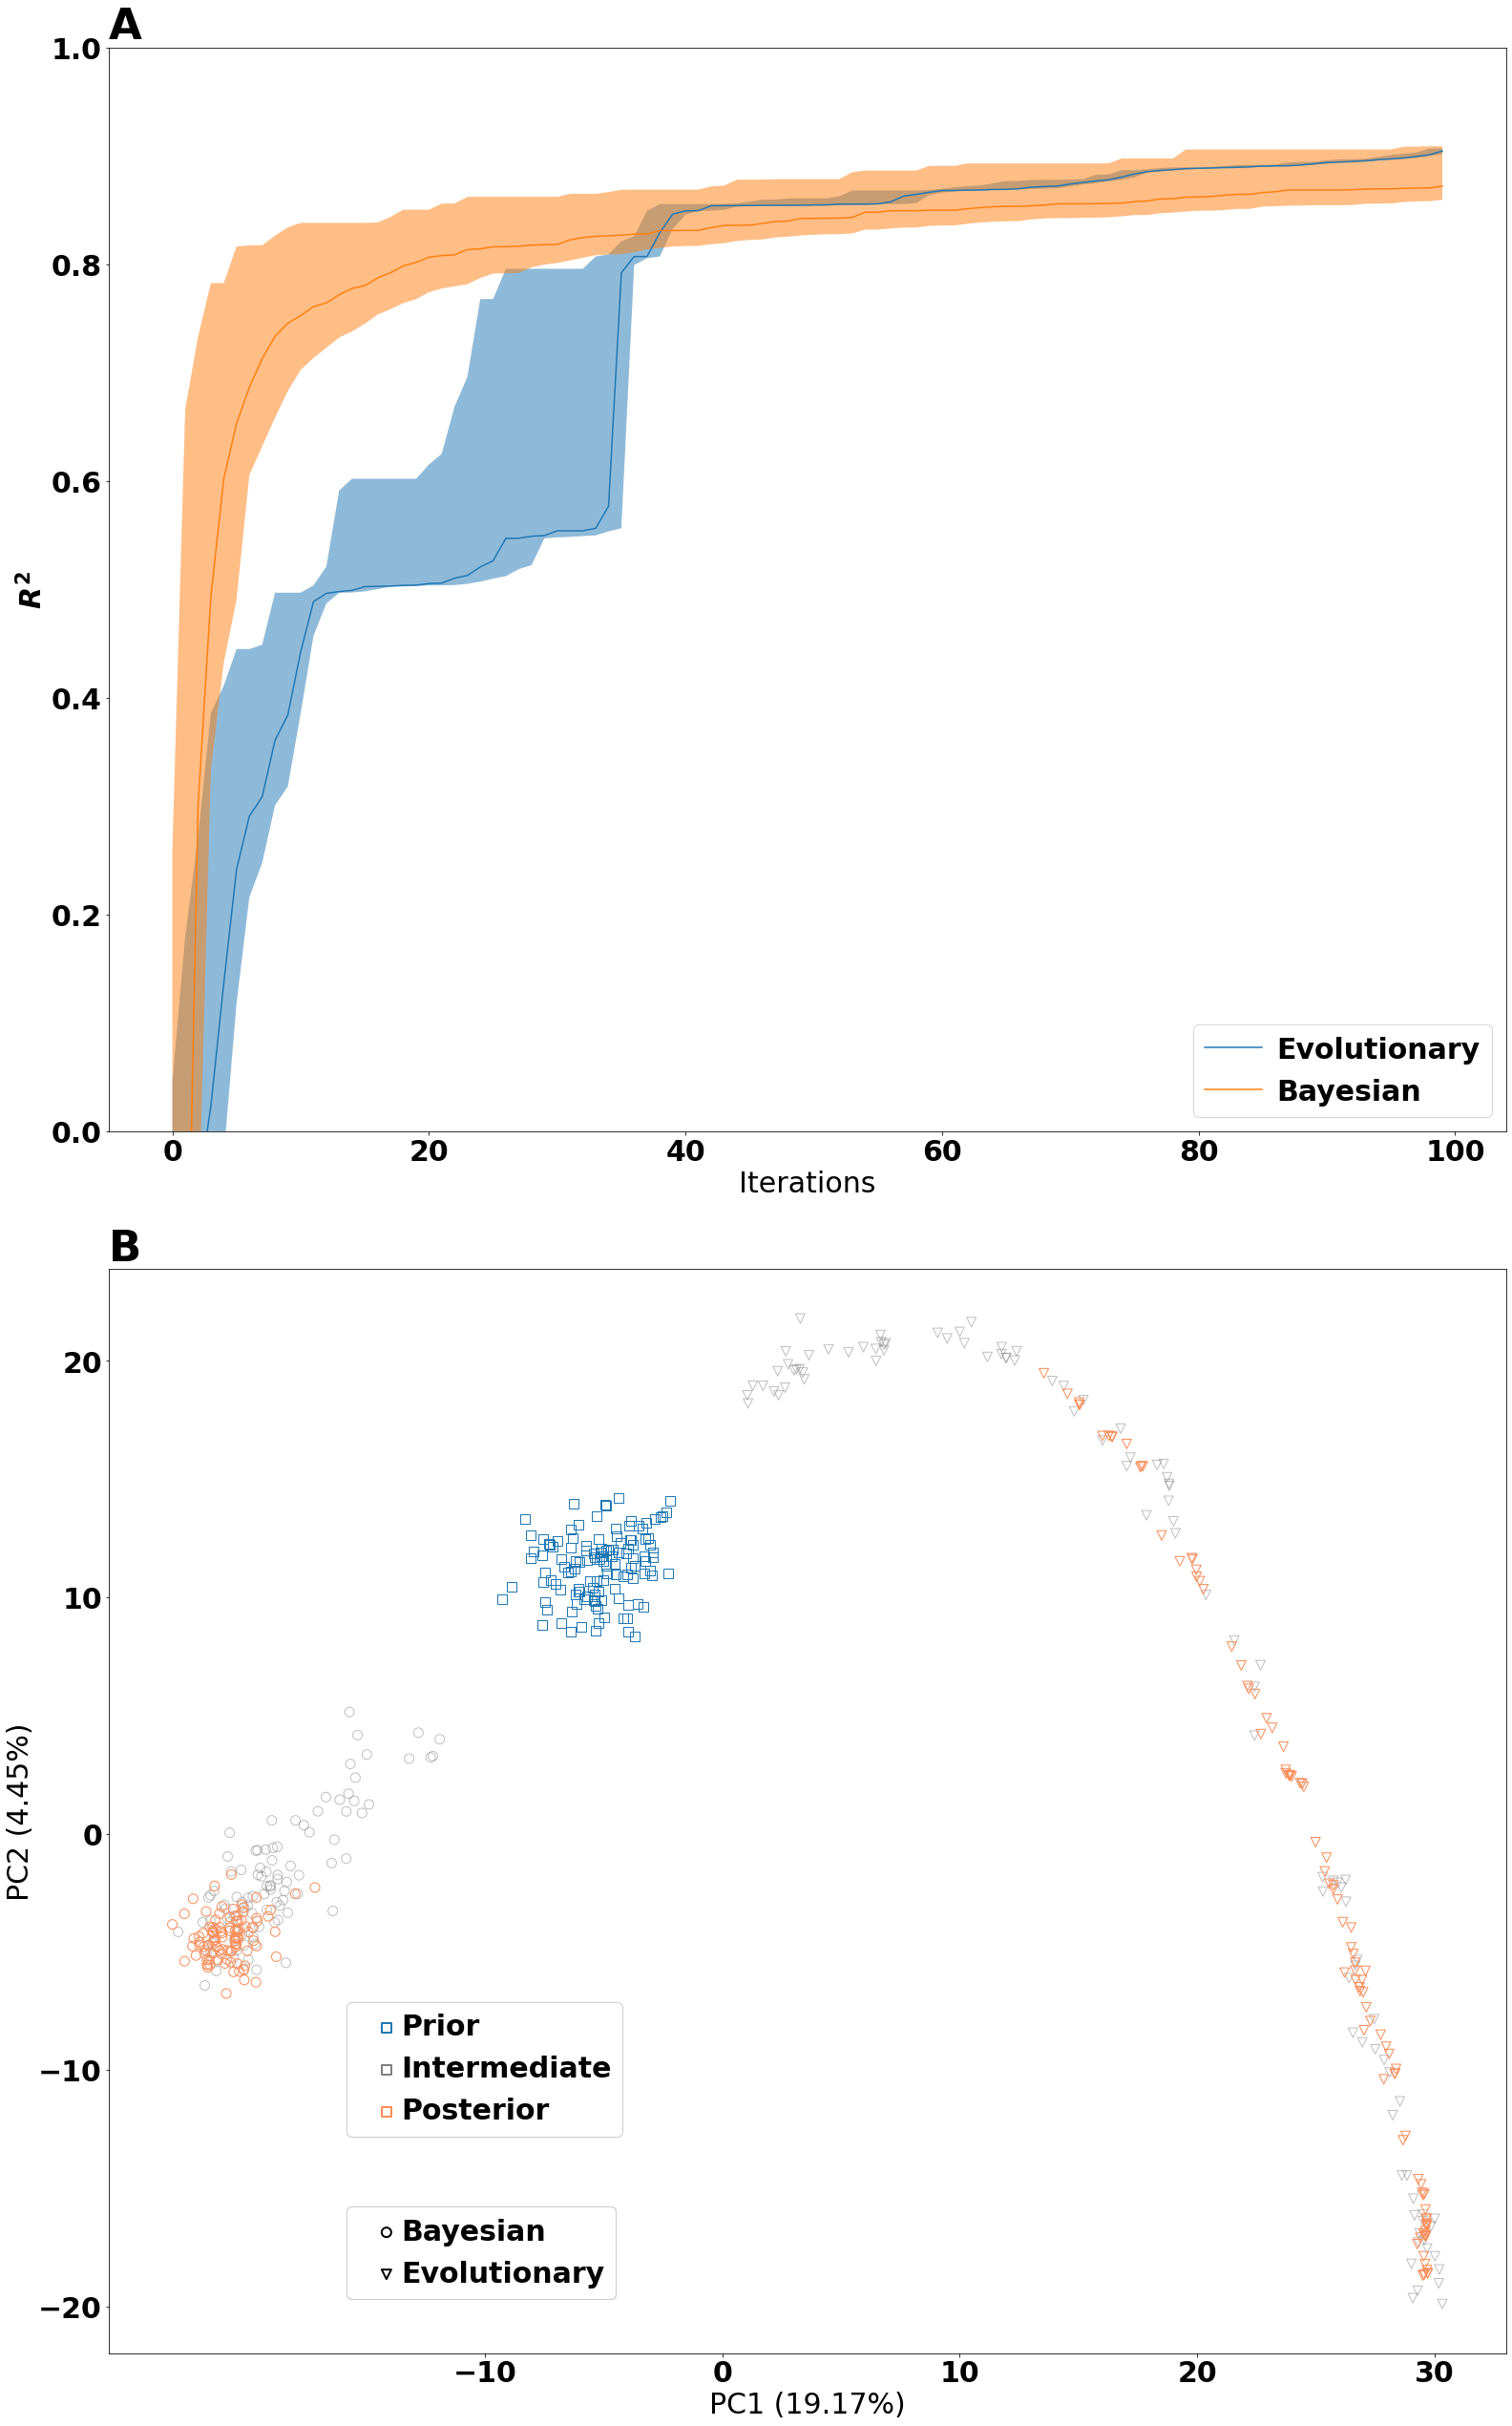

In [91]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
labels_period = ["Prior", "Intermediate", 'Posterior']
labels_status = ['Bayesian', "Evolutionary"]
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)
plt.figure(figsize=(18+5,2*18))
plt.subplot(2,1,1)
plt.title("A",loc="left",fontsize=45,fontweight="bold")
plot_convergence_and_compare_evolution(evolution_distances, reference_distances, maxiter = 100)
plt.subplot(2,1,2)
plt.title("B",loc="left",fontsize=45,fontweight="bold")
create_evo_pca_plot(legend = False)
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in markers]
legend_period = plt.legend(handles_period, labels_period, loc=(.17,.20), framealpha=1, handletextpad=-0.5)
legend_model = plt.legend(handles_model, labels_status, loc=(.17,.05), framealpha=1,handletextpad=-0.5)
plt.gca().add_artist(legend_period)
plt.gca().add_artist(legend_model)
plt.savefig("../figures/evo_fig.png",dpi=200,bbox_inches = 'tight')


In [23]:
np.median(-np.sort(reference_distances)[0:99])

0.9531292853589542

In [24]:
np.median(-np.sort(reference_distances)[0:99])

0.9531292853589542

In [25]:
tsne_frame = load_pickle("../results/evo_tsne_res/tsne_skeleton.pkl")

In [26]:
tsne_frame["ordination"] = list(map(load_pickle, tsne_frame["outfile"]))

[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)
[  129   130   131 ... 63135

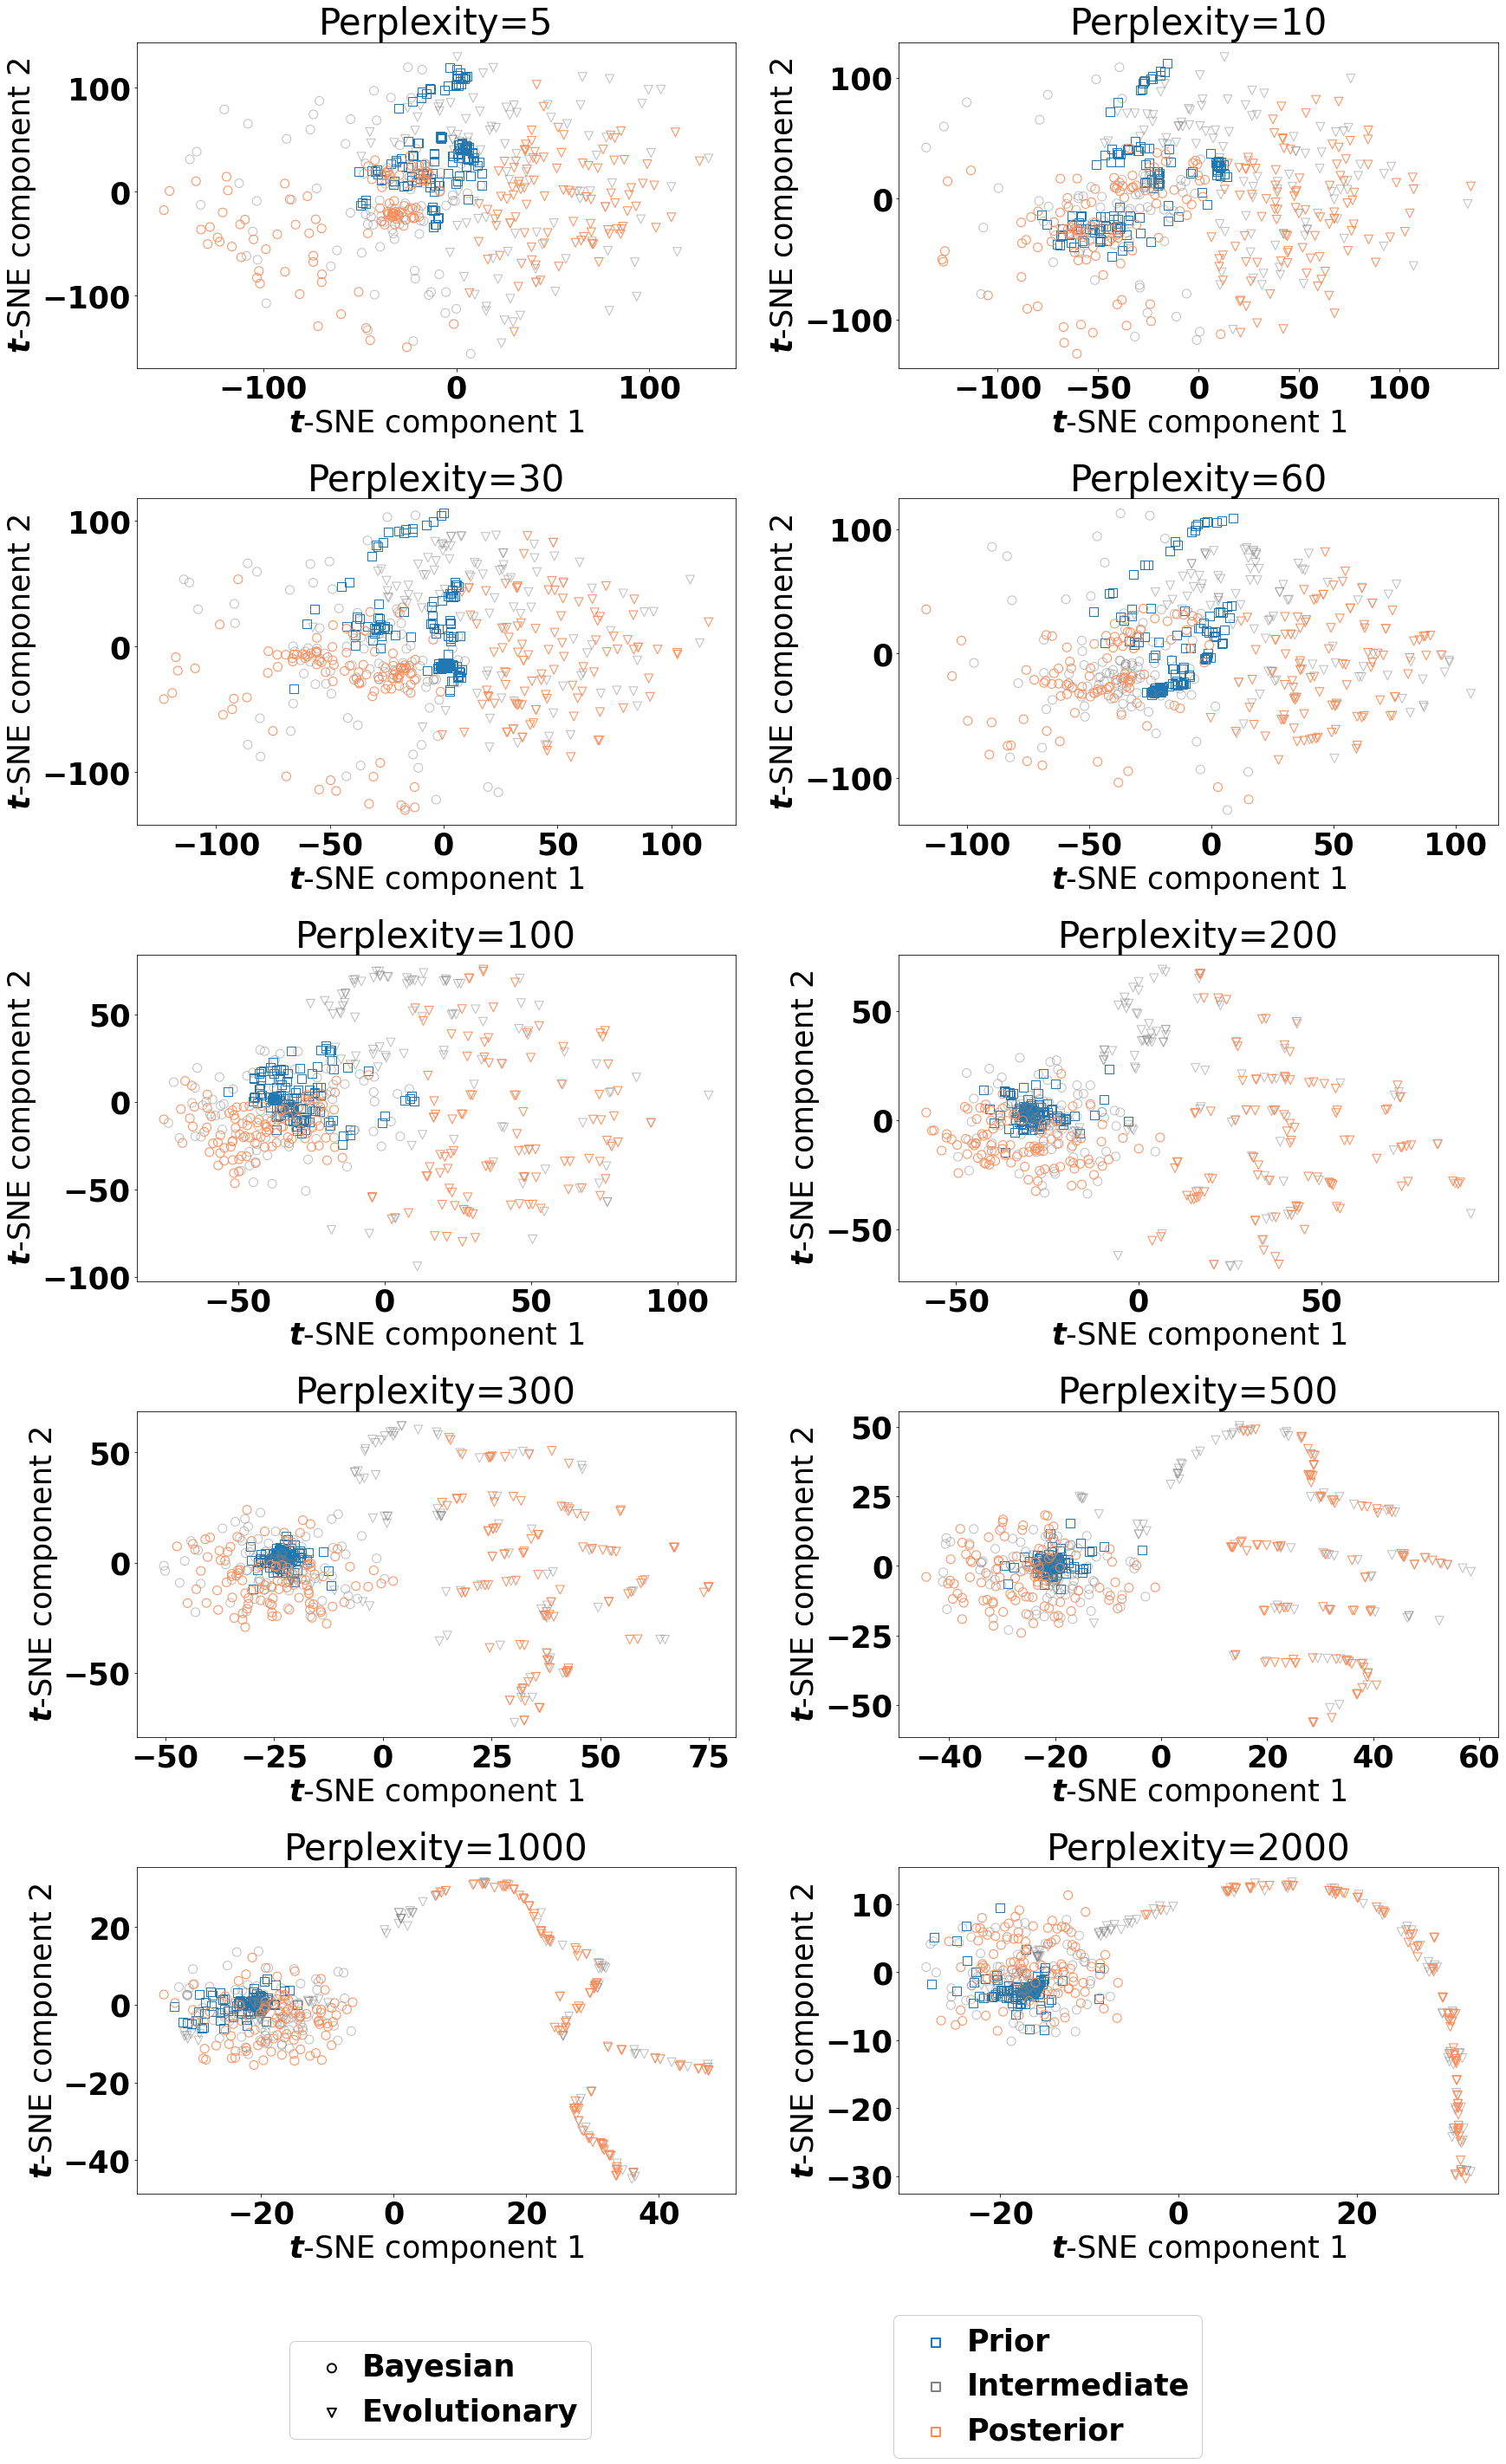

In [90]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 35}
labels_period = ["Prior", "Intermediate", 'Posterior']
labels_status = ['Bayesian', "Evolutionary"]
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)
plt.figure(figsize=(25,40))
model = evolution_combined_df_metadata["model"].to_numpy()
period = evolution_combined_df_metadata["period"].to_numpy()
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
markers = ["o","v"]
marker_dict = {'Bayesian': "o", 'Evolutionary': 'v'}
matplotlib.rc('font', **font)
tsne_thinning_rng = np.random.default_rng(5024)
def create_evo_tsne_plot(tsne_res,legend = True, perplexity = None):
    for label in ["Bayesian","Evolutionary"]:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(this_idxs["Intermediate"])
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])

        this_idxs["Intermediate"] = tsne_thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = tsne_thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        # It does really only make sense display priors for the Bayesian approach as the evolutionary algorithm generates
        # seed individuals by another method and it thus is most fair to show the Bayesian priors for both of them
        if label == "Bayesian":
            plt.scatter(tsne_res[this_idxs['Prior'],0],tsne_res[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                    marker="s",facecolors='none', s=100)
        plt.scatter(tsne_res[this_idxs["Intermediate"],0],tsne_res[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.5,label='Intermediate',marker=marker, facecolors='none',s=100)
        plt.scatter(tsne_res[this_idxs['Posterior'],0],tsne_res[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    plt.xlabel(r'$t$-SNE component 1')
    plt.ylabel(r'$t$-SNE component 2')
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)    
    if perplexity is not None:
        plt.title(f"Perplexity={perplexity}")
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels_period = ["Prior", "Intermediate", 'Posterior']
    labels_status = ['Bayesian', "Evolutionary"]
    if legend:
        f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
        handles_period = [f("s", color) for color in colors]
        handles_model = [f(marker, "k") for marker in markers]
        legend_period = plt.legend(handles_period, labels_period, loc=(.5,-0.35), framealpha=1, handletextpad=0)
        legend_model = plt.legend(handles_model, labels_status, loc=(.1,-0.3), framealpha=1, handletextpad=0)
        plt.gca().add_artist(legend_period)
        plt.gca().add_artist(legend_model)
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in markers]
legend_period = plt.legend(handles_period, labels_period, loc=(.6,-0.16), framealpha=1, handletextpad=0)
legend_model = plt.legend(handles_model, labels_status, loc=(.1,-0.15), framealpha=1, handletextpad=0)

for i, (perplexity,_, ordination) in tsne_frame.iterrows():
    plt.subplot(5,2,i+1)
    create_evo_tsne_plot(ordination,False, perplexity=perplexity)

plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_model)
plt.gcf().subplots_adjust(bottom=.11)
plt.savefig("../figures/evo_tsne.png",dpi=100)
plt.show()

# Particle distance from centroid

In [74]:
particle_RMSD = load_pickle("../results/full_particle_RMSD.pkl").set_index(["origin","status"])

In [75]:
bayesian_RMSD = particle_RMSD.loc[("unpermuted","original")]["RMSD"]
evolutionary_RMSD = particle_RMSD.loc[("unpermuted","evolutionary")]["RMSD"]

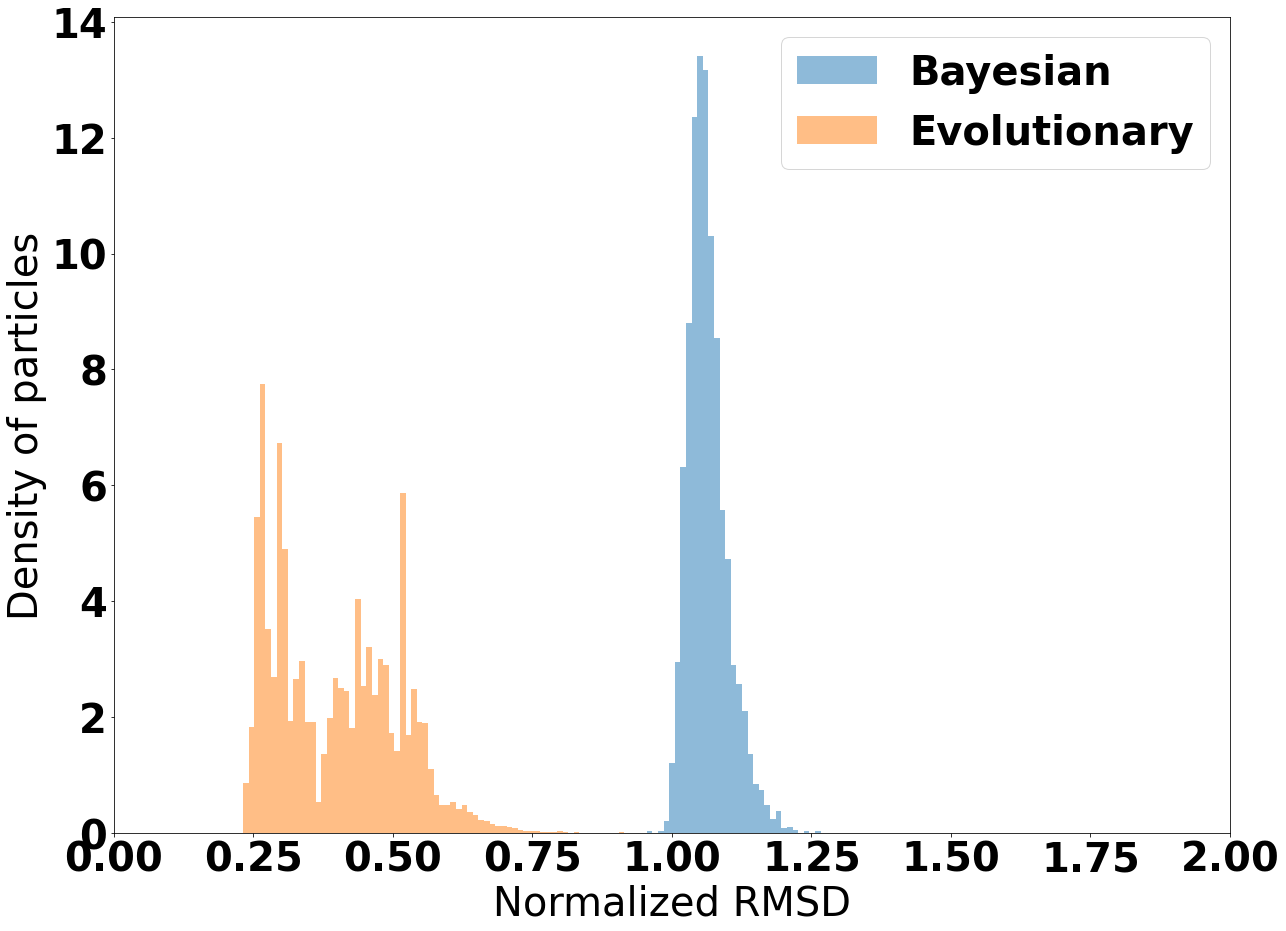

In [88]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}
matplotlib.rc('font', **font)
plt.figure(figsize=(20,15))
bins = np.linspace(0,2,200)
plt.hist(bayesian_RMSD,bins=bins, alpha=0.5, density=True, label="Bayesian")
plt.hist(evolutionary_RMSD,bins=bins,alpha=0.5,density=True, label="Evolutionary")
plt.ylabel("Density of particles")
plt.xlabel("Normalized RMSD")
plt.xlim((0,2))
plt.legend(loc="upper right")
plt.savefig("../figures/RMSD_density.pdf")

# Effects on pathway level

In [40]:
aggregated_fva_res = load_pickle("../results/aggregated_fva_res.pkl")

In [41]:
'r_0961No1' # Pyruvate dehydrogenase
['r_0959No1','r_0959No2','r_0959No3'] # Pyruvate decarboxylase
'r_0450No1' # Fructose-bisphosphate aldolase
'r_0438No1'# Ferrocytochrome-c:oxygen oxidoreductase
'r_0917No1' # Phosphoserine phosphatase
'r_0997No1' # Shikimate kinase
'r_2111' # Growth



signature_reactions = {'PDH': 'r_0961No1', 'FBA': 'r_0450No1', 'FCO': 'r_0438No1', 'PSP': 'r_0917No1', 'SHK': 'r_0997No1', 'GRW': 'r_2111'}
signature_full_name = {'PDH': 'Pyruvate dehydrogenase', 'FBA': 'Fructose-bisphosphate aldolase', 'FCO': 'Ferrocytochrome-c:oxygen oxidoreductase',
                       'PSP': 'Phosphoserine phosphatase', 'SHK': 'Shikimate kinase', 'GRW': "Growth"}

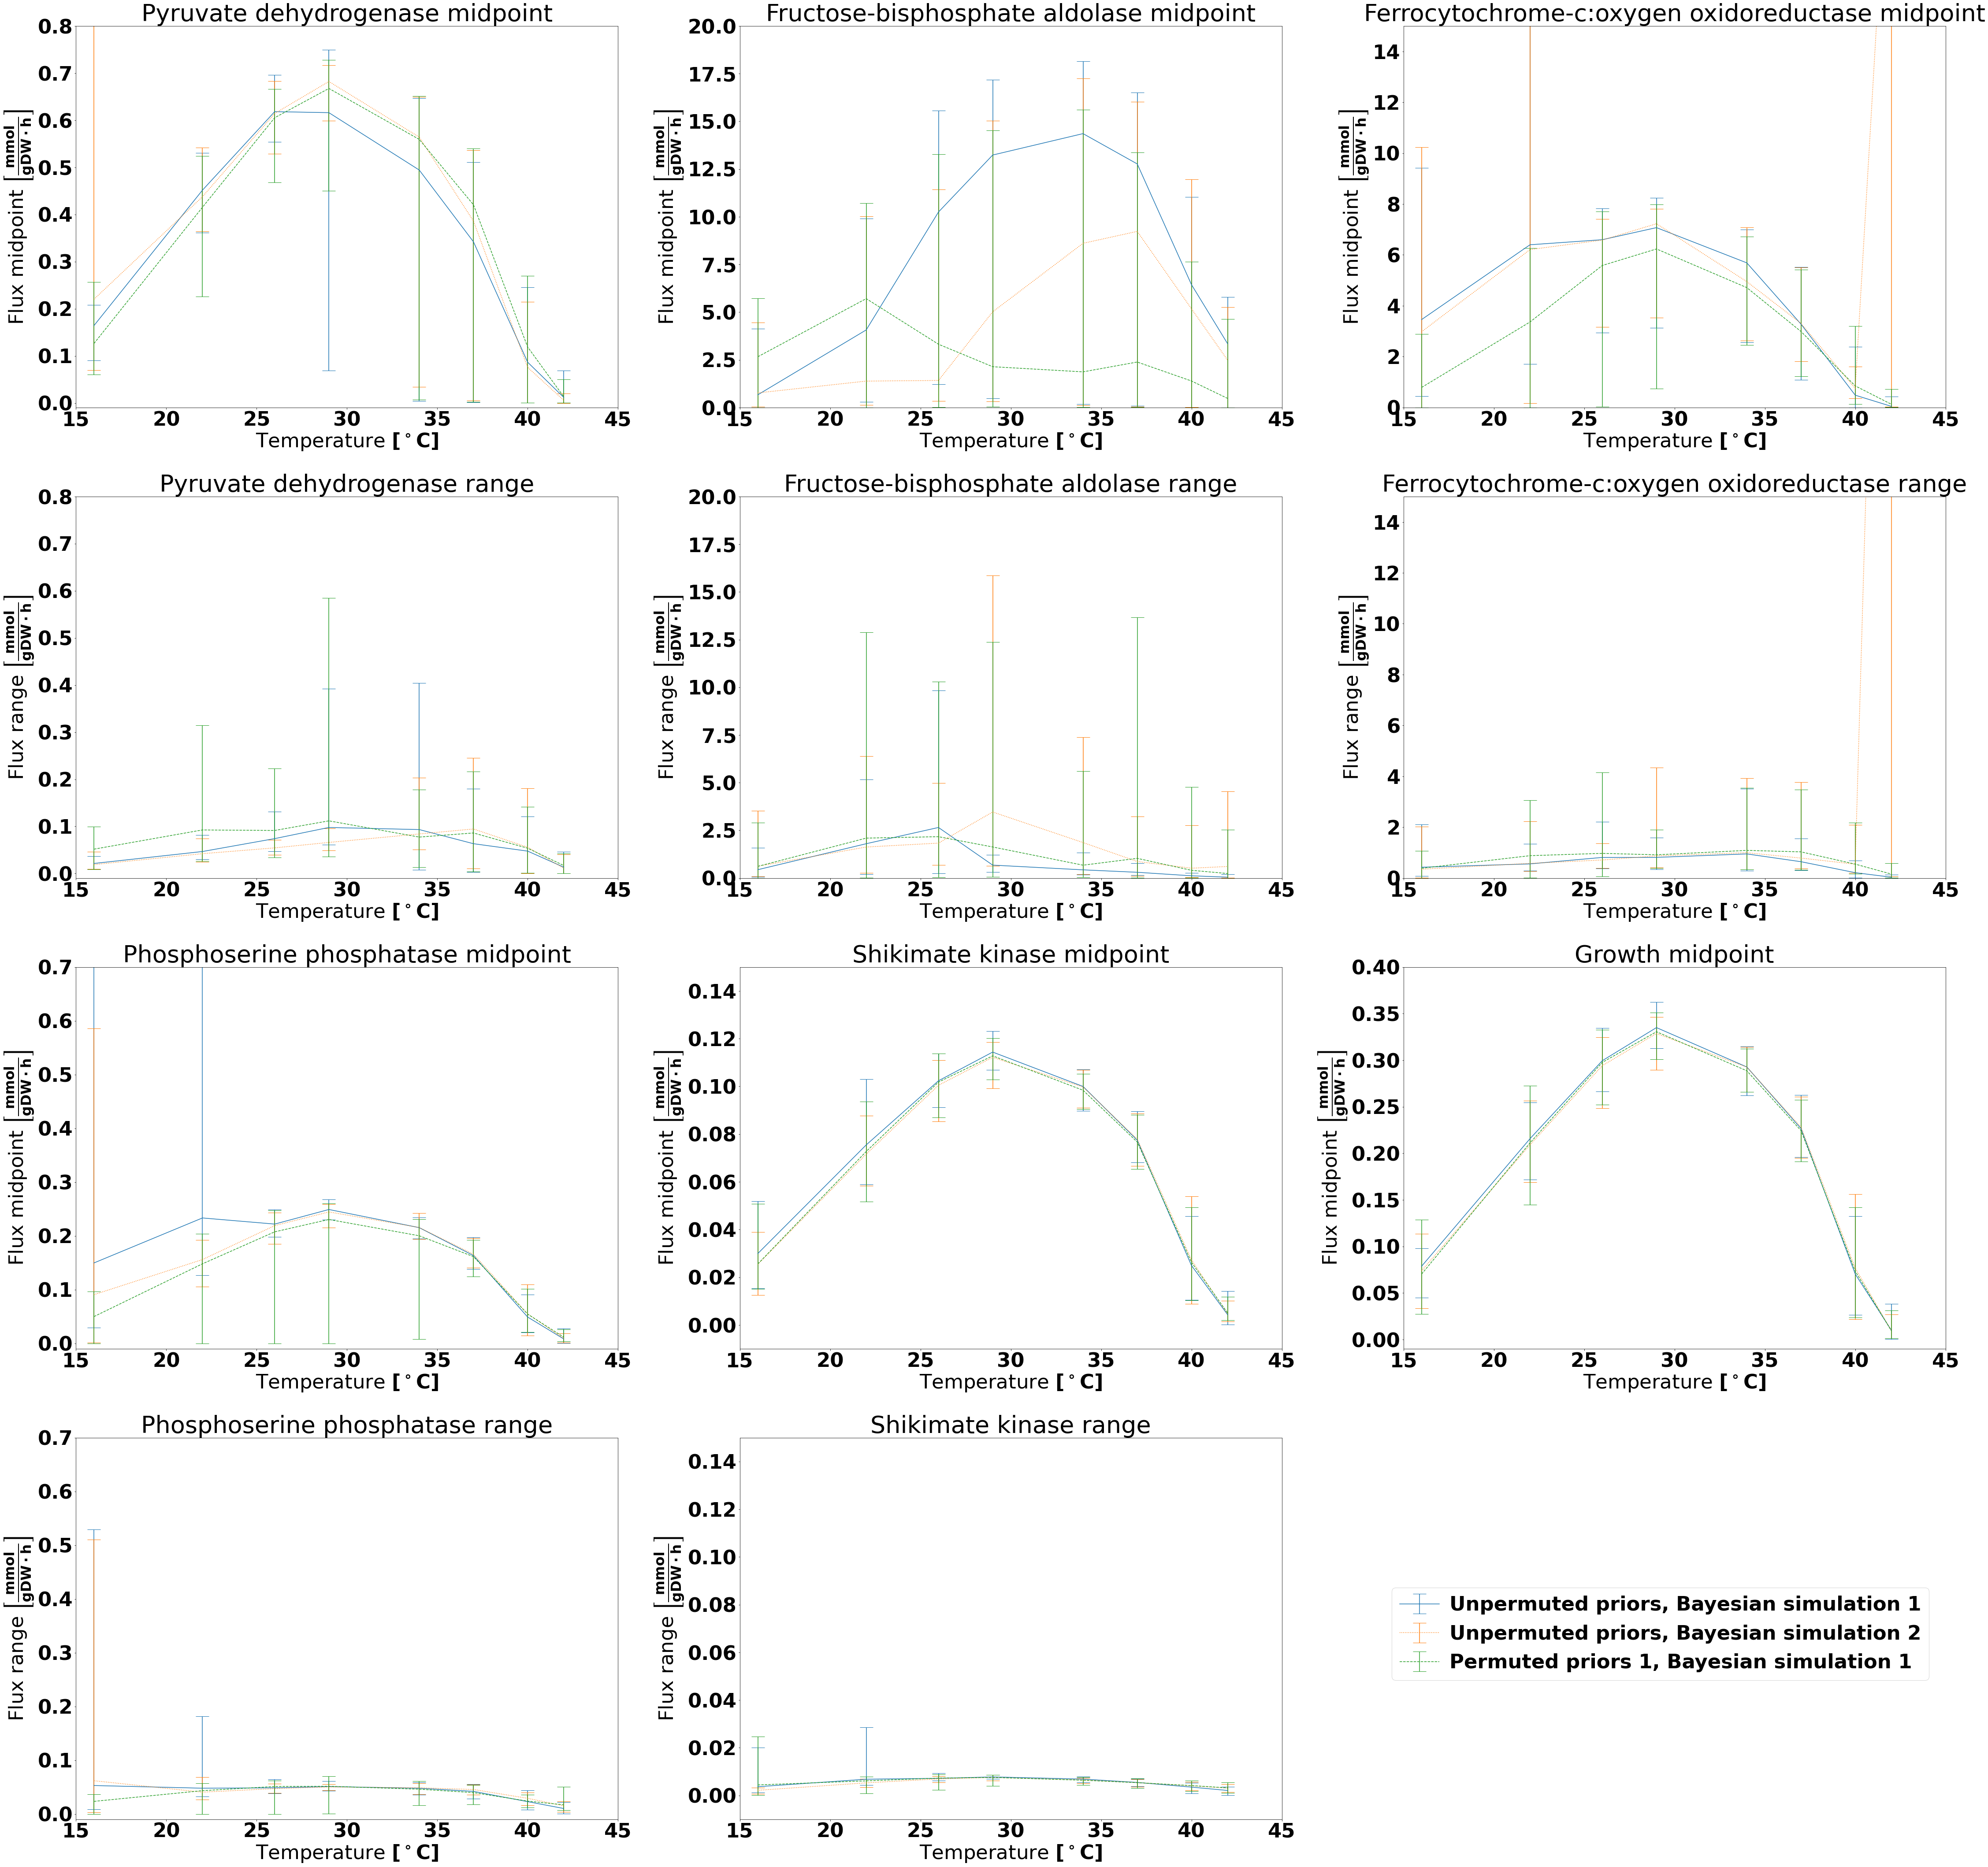

In [44]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Unpermuted priors, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="replicate",reaction=reaction, what=what, linestyle="dotted",condition="aerobic",label = "Unpermuted priors, Bayesian simulation 2")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="aerobic", label = "Permuted priors 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/aerobic_fva.pdf")

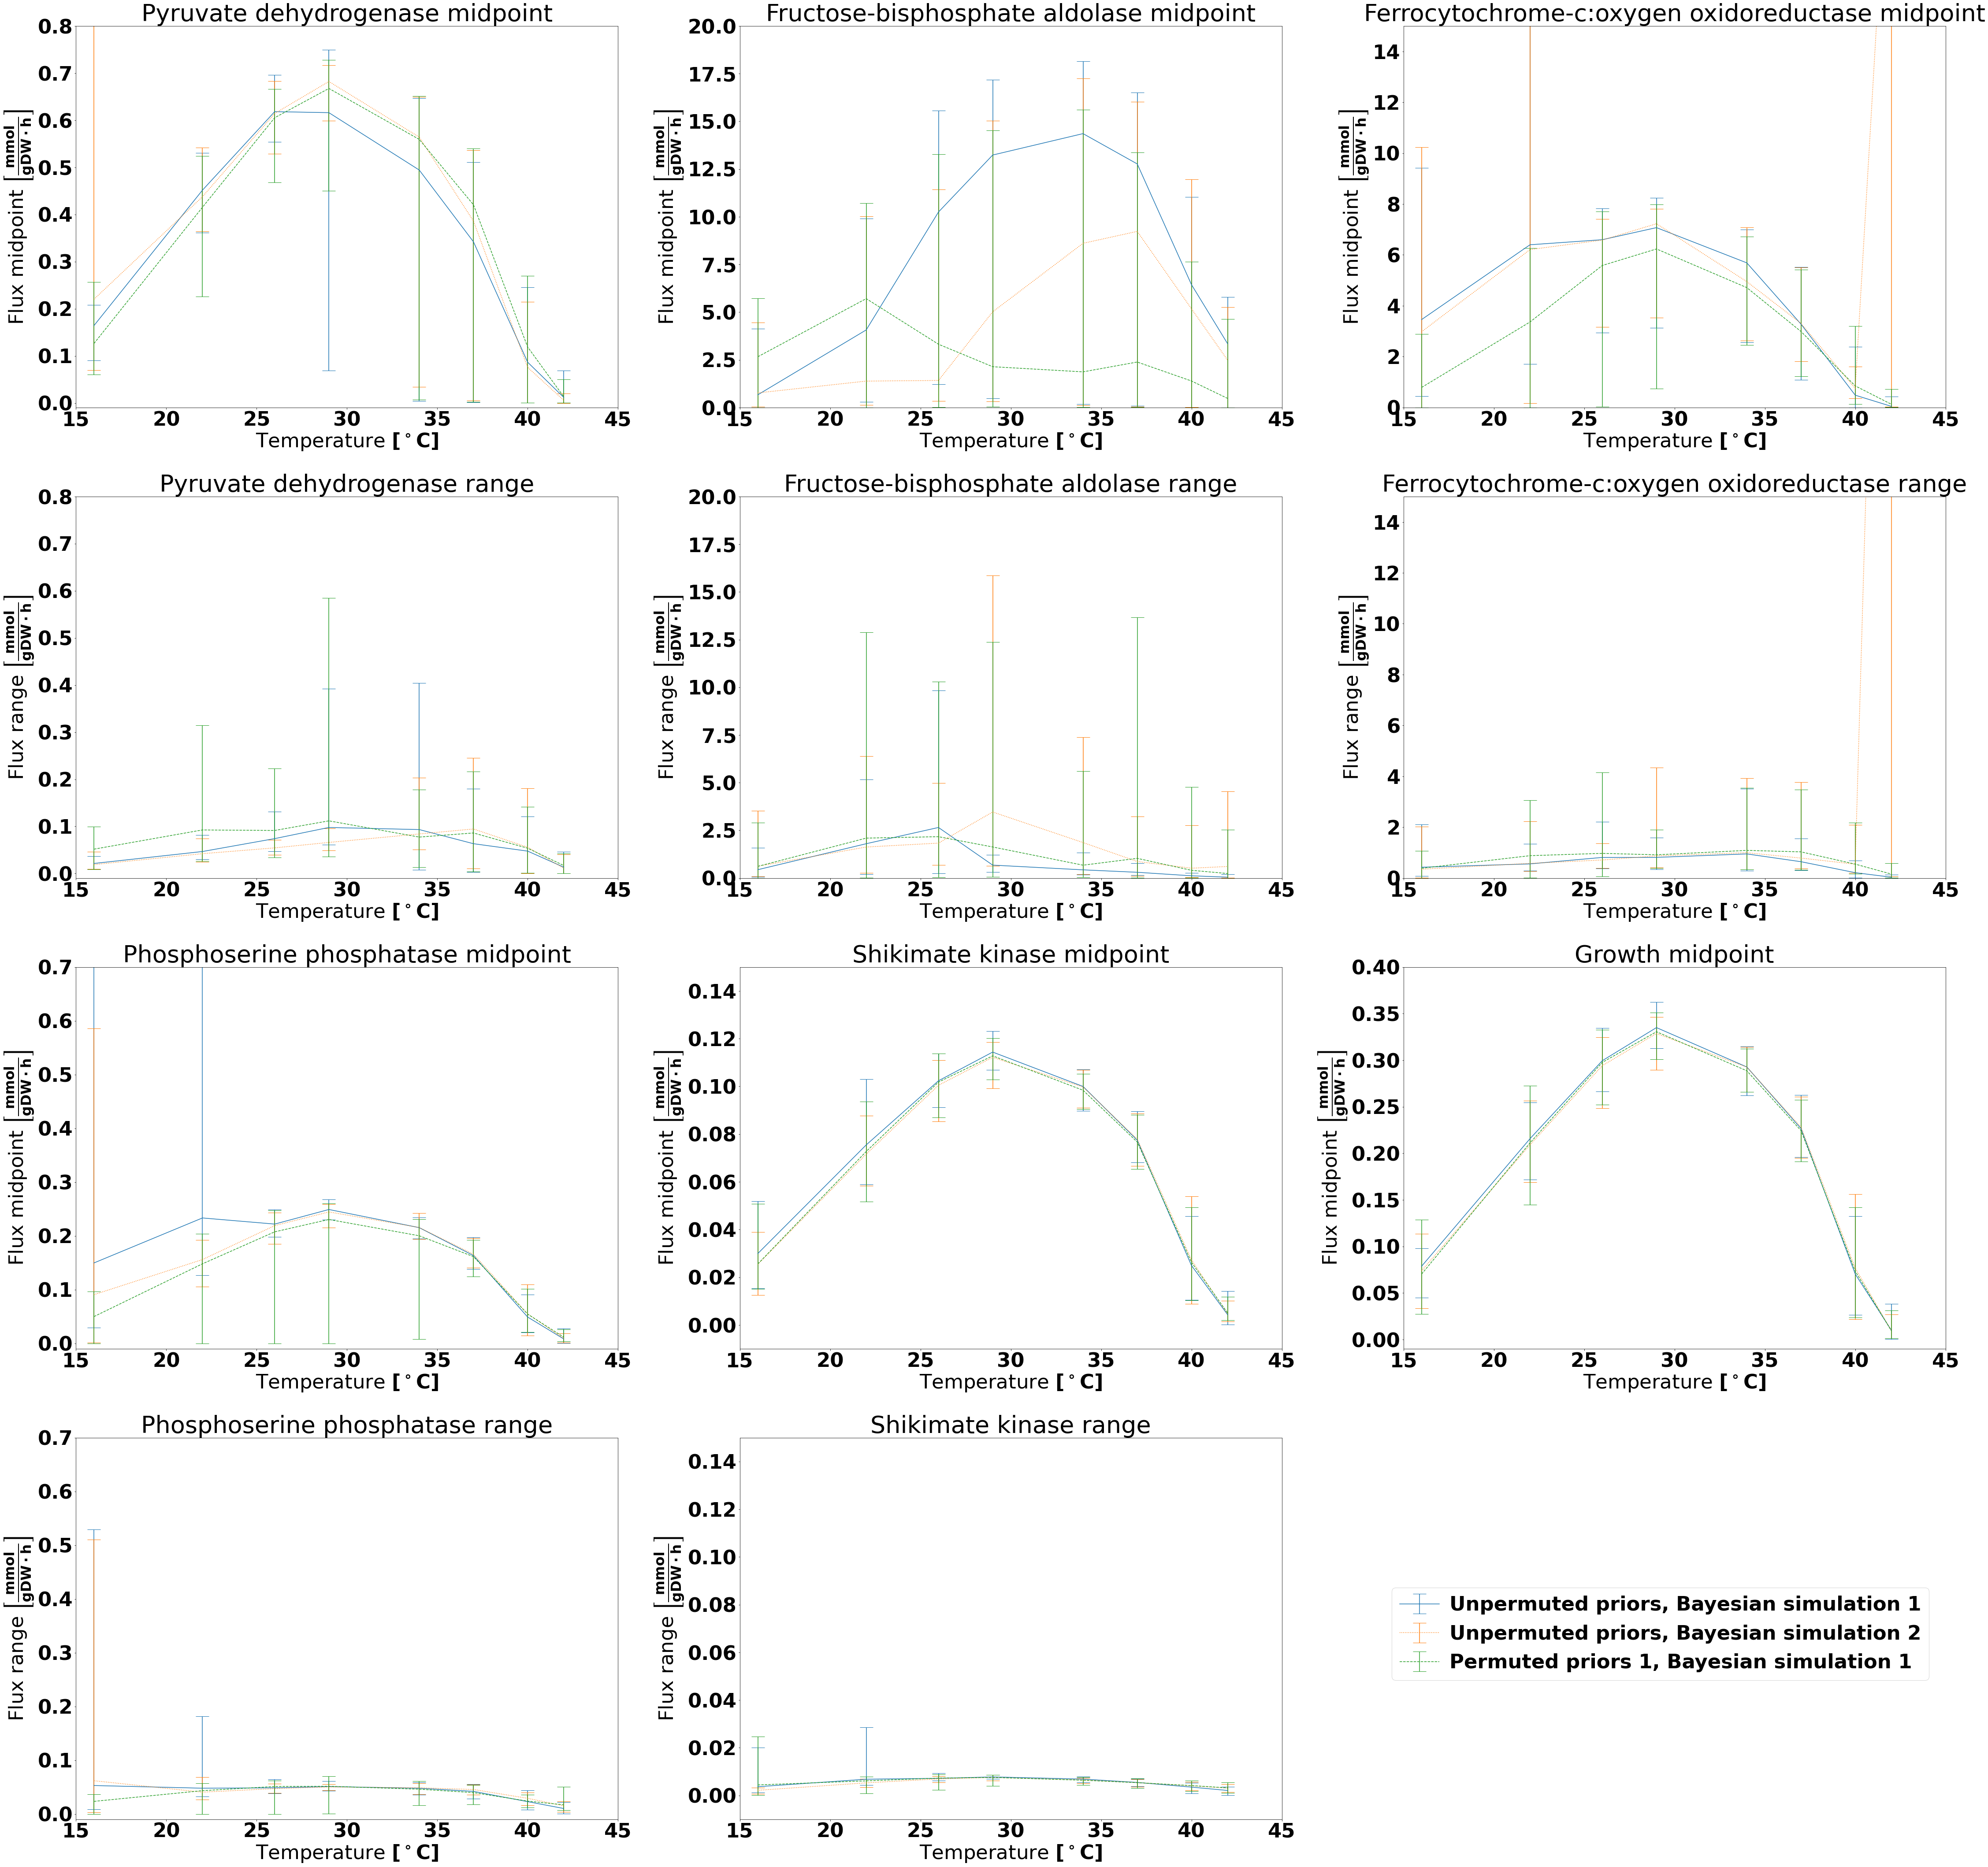

In [46]:
reactions = signature_reactions.keys()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
matplotlib.rc('font', **font)
T_0 = 273.15
def extract_results_and_plot(origin,status,reaction, what, linestyle,condition="aerobic",label=""):
    react_id = signature_reactions[reaction]
    subsetted_frame = aggregated_fva_res.reset_index().pipe(lambda df: df[(df["origin"] == origin) & (df["status"] == status) & (df["reaction"] == react_id) & (df["condition"] == condition)])
    T = subsetted_frame[("T","")]
    mu = subsetted_frame[(what,"mean")]
    minimum = subsetted_frame[(what,"min")]
    maximum = subsetted_frame[(what,"max")]
    plt.errorbar(T-T_0,mu,yerr=np.row_stack((mu-minimum,maximum-mu)),markersize=8,capsize=15,linestyle=linestyle, label=label)
    return
    
plt.figure(figsize=(63,60))
nrows = 4
ncols = 3
i = 1
subplot_order = {1: 1, 2: 4, 3: 2, 4: 5, 5: 3, 6: 6, 7: 7, 8: 10, 9: 8, 10: 11, 11: 9, 12: 12}
ymaxs = {"PDH": 0.8, "FBA": 20, "FCO": 15, "PSP": 0.7, "SHK": 0.15, 'GRW': 0.4 }
for reaction in reactions:
    for what in ["midpoint", "range"]:
        if i == 12:
            # The growth range is not interesting, so we use it for legend instead
            continue
        plt.subplot(4,3,subplot_order[i])
        extract_results_and_plot(origin="unpermuted",status="original",reaction=reaction, what=what, linestyle="solid",condition="aerobic", label = "Unpermuted priors, Bayesian simulation 1")
        extract_results_and_plot(origin="unpermuted",status="replicate",reaction=reaction, what=what, linestyle="dotted",condition="aerobic",label = "Unpermuted priors, Bayesian simulation 2")
        extract_results_and_plot(origin="permuted_0",status="original",reaction=reaction, what=what, linestyle="dashed",condition="aerobic", label = "Permuted priors 1, Bayesian simulation 1" )
        plt.ylabel(r"Flux range $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$" if what == "range"
               else r"Flux midpoint $\left[\frac{\mathrm{mmol}}{\mathrm{gDW}\cdot \mathrm{h}}\right]$")
        plt.xlabel(r"Temperature $\left[^\circ\mathrm{C}\right]$")
        plt.title(f"{signature_full_name[reaction]} {what}")
        plt.xlim((15,45))
        plt.ylim((-0.01,ymaxs[reaction]))
        if i == 10:
            handles, labels = plt.gca().get_legend_handles_labels()
        i += 1
        plt.tight_layout()
plt.gcf().legend(handles,labels, loc=(.7,0.1),ncol=1,handletextpad=0.5)
plt.savefig("../figures/anaerobic_fva.pdf")